<a href="https://colab.research.google.com/github/matthew9671/MattLab/blob/main/parallel_kalman_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parallel Kalman Sampling

Sarkka et al derived a parallel message passing algorithm for Kalman _smoothing_, but how do we adjust this algorithm to samlpe from the posterior of linear Gaussian SSM. 

Suppose we have already computed the filtering distributions (e.g. using the parallel Kalman filter). Now we would like to sample the posterior. To do so we need to define a binary associative operator that takes in two elements and outputs one of the same type. 

In the smoother, the initial elements are,
\begin{align*}
a_t &= p(x_t \mid y_{1:t}, x_{t+1})
\end{align*}
The binary operator takes in two elements and outputs one,
\begin{align*}
a_t \otimes a_{t+1} &= \int p(x_t \mid y_{1:t}, x_{t+1}) \, p(x_{t+1} \mid y_{1:t+1}, x_{t+2}) \, \mathrm{d}x_{t+1} \\
&= p(x_t \mid y_{1:t+1}, x_{t+2}) 
\end{align*}
Since the model is linear and Gaussian, each of these conditional distributions is a Gaussian whose mean is linear in the future state,
\begin{align*}
a_t &= p(x_t \mid y_{1:t}, x_{t+1}) 
= \mathcal{N}(x_t \mid E_{t,t+1} x_{t+1} + g_{t,t+1}, L_{t,t+1})
\end{align*}
(adapting Sarkka's notation)

## Parallel sampling

For the sampler, let's try reparameterizing the distribution above 
\begin{align*}
a_t &= E_{t,t+1} x_{t+1} + g_{t,t+1} + L_{t,t+1}^{1/2} \epsilon_t \\
&= E_{t,t+1} x_{t+1} + h_{t,t+1}
\end{align*}
where $h_{t,t+1} = g_{t,t+1} + L_{t,t+1}^{1/2} \epsilon_t$ and $\epsilon_t \sim \mathcal{N}(0,I)$. Then $a_t \sim p(x_t \mid y_{1:t}, x_{t+1})$.

The associated binary operator must be,
\begin{align*}
a_t \otimes a_{t+1} &= E_{t,t+1} (E_{t+1,t+2} x_{t+2} + h_{t+1,t+2}) + h_{t,t+1} \\
&= E_{t,t+1} E_{t+1,t+2} x_{t+2} + E_{t,t+1} h_{t+1,t+2} + h_{t,t+1} \\
&= E_{t,t+2} x_{t+2} + h_{t,t+2}
\end{align*}
where
\begin{align*}
E_{t,t+2} &\triangleq E_{t,t+1} E_{t+1,t+2} \\
h_{t,t+2} &\triangleq E_{t,t+1} h_{t+1,t+2} + h_{t,t+1}
\end{align*}

In [ ]:
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsc
from jax import vmap, lax
from jaxtyping import Array, Float
from tensorflow_probability.substrates import jax as tfp 

from dynamax.utils.utils import psd_solve
from dynamax.linear_gaussian_ssm import LinearGaussianSSM
from dynamax.linear_gaussian_ssm.inference import PosteriorGSSMFiltered, PosteriorGSSMSmoothed, ParamsLGSSM
from dynamax.linear_gaussian_ssm import parallel_lgssm_filter, parallel_lgssm_smoother


MVN = tfp.distributions.MultivariateNormalFullCovariance

In [ ]:
def _make_associative_sampling_elements(params, key, filtered_means, filtered_covariances):
    """Preprocess filtering output to construct input for smoothing assocative scan."""

    def _last_sampling_element(key, m, P):
        return jnp.zeros_like(P), MVN(m, P).sample(seed=key)

    def _generic_sampling_element(params, key, m, P):
        F = params.dynamics.weights
        H = params.emissions.weights
        Q = params.dynamics.cov
        R = params.emissions.cov

        Pp = F @ P @ F.T + Q

        E  = psd_solve(Pp, F @ P).T
        g  = m - E @ F @ m
        L  = P - E @ Pp @ E.T
        h = MVN(g, L).sample(seed=key)
        return E, h

    num_timesteps = len(filtered_means)
    keys = jr.split(key, num_timesteps)
    last_elems = _last_sampling_element(keys[-1], filtered_means[-1], filtered_covariances[-1])
    generic_elems = vmap(_generic_sampling_element, (None, 0, 0, 0))(
        params, keys[:-1], filtered_means[:-1], filtered_covariances[:-1]
        )
    combined_elems = tuple(jnp.append(gen_elm, last_elm[None,:], axis=0)
                           for gen_elm, last_elm in zip(generic_elems, last_elems))
    return combined_elems


def parallel_lgssm_posterior_sample(
    params: ParamsLGSSM,
    key,
    emissions: Float[Array, "ntime emission_dim"]
) -> PosteriorGSSMSmoothed:
    """A parallel version of the lgssm smoothing algorithm.

    See S. Särkkä and Á. F. García-Fernández (2021) - https://arxiv.org/abs/1905.13002.

    Note: This function does not yet handle `inputs` to the system.
    """
    filtered_posterior = parallel_lgssm_filter(params, emissions)
    filtered_means = filtered_posterior.filtered_means
    filtered_covs = filtered_posterior.filtered_covariances
    initial_elements = _make_associative_sampling_elements(params, key, filtered_means, filtered_covs)

    @vmap
    def sampling_operator(elem1, elem2):
        E1, h1 = elem1
        E2, h2 = elem2

        E = E2 @ E1
        h = E2 @ h1 + h2
        return E, h

    _, sample = \
        lax.associative_scan(sampling_operator, initial_elements, reverse=True)
        
    return sample

In [ ]:
seed=0

dt = 0.1
F = jnp.eye(4) + dt * jnp.eye(4, k=2)
Q = 1. * jnp.kron(jnp.array([[dt**3/3, dt**2/2],
                      [dt**2/2, dt]]),
                 jnp.eye(2))
H = jnp.eye(2, 4)
R = 0.5 ** 2 * jnp.eye(2)
μ0 = jnp.array([0.,0.,1.,-1.])
Σ0 = jnp.eye(4)

latent_dim = 4
observation_dim = 2

lgssm = LinearGaussianSSM(latent_dim, observation_dim)
model_params, _ = lgssm.initialize(jr.PRNGKey(0),
                         initial_mean=μ0,
                         initial_covariance=Σ0,
                         dynamics_weights=F,
                         dynamics_covariance=Q,
                         emission_weights=H,
                         emission_covariance=R)
inf_params = model_params

num_timesteps = 50
key = jr.PRNGKey(seed)
key, subkey = jr.split(key)
_, emissions = lgssm.sample(model_params, subkey, num_timesteps)

parallel_posterior = parallel_lgssm_smoother(inf_params, emissions)

num_samples = 20
f = vmap(partial(parallel_lgssm_posterior_sample, inf_params, emissions=emissions))
parallel_samples = f(jr.split(key, num_samples))


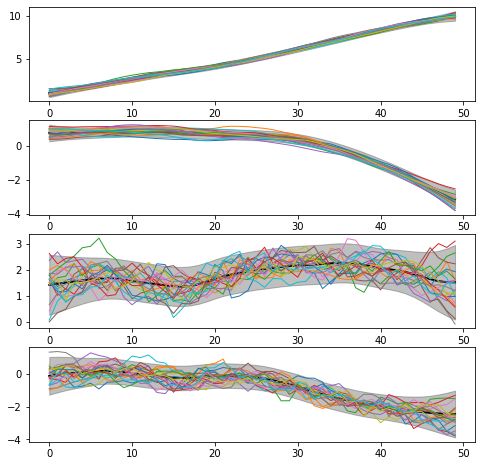

In [ ]:
import matplotlib.pyplot as plt

post_mean = parallel_posterior.smoothed_means
post_std = jnp.sqrt(parallel_posterior.smoothed_covariances[:, jnp.arange(latent_dim), jnp.arange(latent_dim)])

fig, axs = plt.subplots(latent_dim, 1, figsize=(8, latent_dim*2))
for d in range(latent_dim):
    axs[d].plot(jnp.arange(num_timesteps), post_mean[:, d], '-k', lw=2)
    axs[d].fill_between(jnp.arange(num_timesteps),
                        post_mean[:,d] - 2 * post_std[:,d],
                        post_mean[:,d] + 2 * post_std[:,d],
                        color='k', alpha=0.25)
    axs[d].plot(parallel_samples[:, :, d].T, lw=1)

Looks like it's working! 